In [1]:
import numpy as np  # linear algebra
import pandas as pd # data process cvs file 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# results writen to current dir are saved as output
import pandas as pd
import xgboost as xgb
from decimal import Decimal
from IPython.display import display
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

data = pd.read_csv("/kaggle/input/nba-games-stats-from-2014-to-2018/nba.games.stats.csv")

/kaggle/input/nba-games-stats-from-2014-to-2018/nba.games.stats.csv


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d32bdcb70>,
      dtype=object)

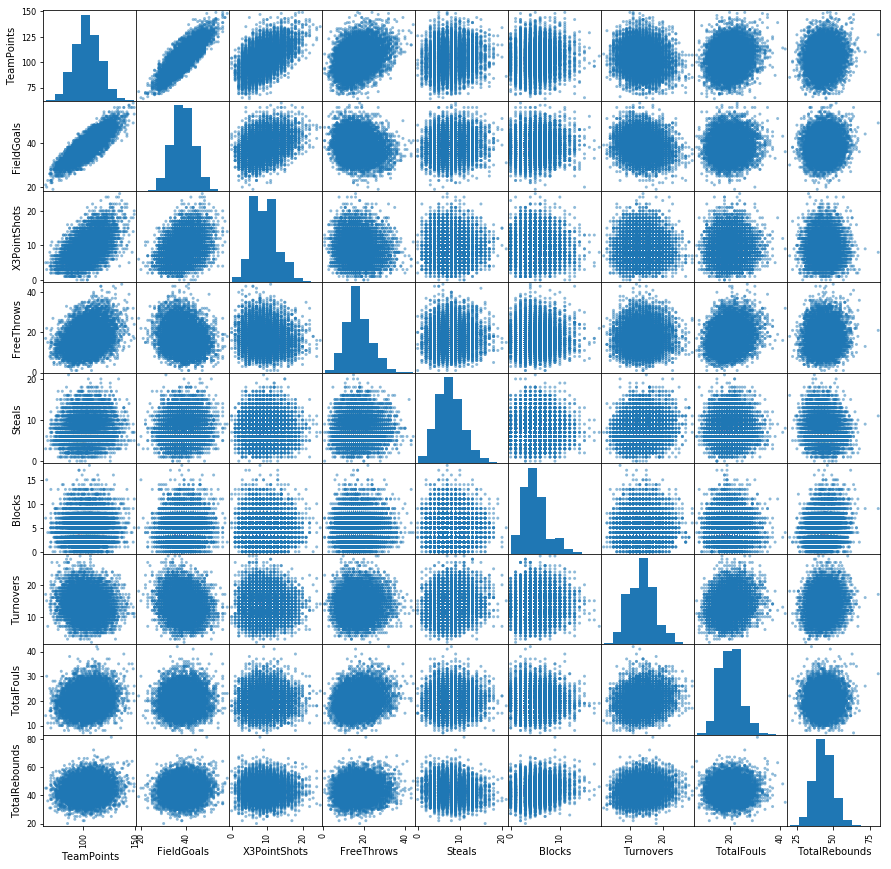

In [2]:
# observing data relationships
scatter_matrix(data[['TeamPoints', 'FieldGoals', 'X3PointShots', 'FreeThrows', 'Steals', 'Blocks', 'Turnovers', 'TotalFouls', 'TotalRebounds']], figsize=(15,15))

In [3]:
# prep data
X_all = data.drop(['WINorLOSS', 'Date', 'OpponentPoints', 'Opp.FieldGoals','Opp.FieldGoalsAttempted','Opp.FieldGoals.','Opp.3PointShots',
                   'Opp.3PointShotsAttempted','Opp.3PointShots.','Opp.FreeThrows','Opp.FreeThrowsAttempted','Opp.FreeThrows.',
                   'Opp.OffRebounds','Opp.TotalRebounds','Opp.Assists','Opp.Steals','Opp.Blocks','Opp.Turnovers','Opp.TotalFouls'], 1)
Y_all = data['WINorLOSS']

In [4]:
# this standardizes the data, by normalizing it on a scale of -1 to 1
from sklearn.preprocessing import scale

# centralize the mean and component-wise scale to unit variance.
cols = [["TeamPoints","FieldGoals","FieldGoalsAttempted","FieldGoals.","X3PointShots",
         "X3PointShotsAttempted","X3PointShots.","FreeThrows","FreeThrowsAttempted","FreeThrows.","OffRebounds","TotalRebounds",
         "Assists","Steals","Blocks","Turnovers","TotalFouls"]]
for col in cols:
    X_all[col] = scale(X_all[col])
    

In [5]:
# remove catagorical variables if necessary
def remove_cats(unscaledX):
    ''' Preprocesses the basketball data and converts categorical variables into dummy variables. '''
    
    # initialize new DataFrame
    output = pd.DataFrame(index = unscaledX.index)

    # investigate each feature column for data
    for col, col_data in unscaledX.iteritems():

        # convert to dummy if catagorical
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
                    
        output = output.join(col_data)
    
    return output

X_all = remove_cats(X_all)
display(X_all.head())



,Unnamed: 0,Team_ATL,Team_BOS,Team_BRK,Team_CHI,Team_CHO,Team_CLE,Team_DAL,Team_DEN,Team_DET,...,FreeThrows,FreeThrowsAttempted,FreeThrows.,OffRebounds,TotalRebounds,Assists,Steals,Blocks,Turnovers,TotalFouls
0,1,1,0,0,0,0,0,0,0,0,...,-1.386237,-0.777988,-2.237904,-0.075547,-0.237224,0.674144,-0.591641,1.250577,0.868721,0.912927
1,2,1,0,0,0,0,0,0,0,0,...,1.279401,1.387078,-0.042141,-1.914300,-1.017243,0.674144,0.760288,0.462156,-0.423487,-0.013558
2,3,1,0,0,0,0,0,0,0,0,...,-1.552839,-1.589888,-0.339384,-0.075547,-1.017243,0.674144,2.112217,0.067945,-0.165045,1.144548
3,4,1,0,0,0,0,0,0,0,0,...,0.446389,0.439862,0.063333,-0.863584,-0.861239,1.064561,0.084324,-0.720476,1.385604,2.997519
4,5,1,0,0,0,0,0,0,0,0,...,1.779208,1.793028,0.149629,0.449811,-0.393228,-0.887524,0.760288,0.067945,-1.457253,-0.708422


In [6]:
from sklearn.model_selection import train_test_split

# randomly split data into two sets: test and train
training_set_x, testing_set_x, training_set_y, testing_set_y = train_test_split(X_all, Y_all, 
                                                    test_size = 50,
                                                    random_state = 2,
                                                    stratify = Y_all)

display(training_set_x)
display(training_set_y)

display(testing_set_x)
display(testing_set_y)

,Unnamed: 0,Team_ATL,Team_BOS,Team_BRK,Team_CHI,Team_CHO,Team_CLE,Team_DAL,Team_DEN,Team_DET,...,FreeThrows,FreeThrowsAttempted,FreeThrows.,OffRebounds,TotalRebounds,Assists,Steals,Blocks,Turnovers,TotalFouls
9631,38117,0,0,0,0,0,0,0,0,0,...,0.113185,0.033912,0.197572,-0.600905,1.166810,-0.692316,-0.253658,2.827419,0.351838,1.607791
634,6111,0,0,0,0,0,0,0,1,0,...,-1.552839,-1.725204,0.360576,0.975169,1.166810,0.869352,0.084324,-0.720476,-0.165045,0.218063
6202,5375,0,0,0,0,0,0,0,0,0,...,-0.719827,-0.642671,-0.387326,0.975169,0.698799,0.088518,-0.929623,0.067945,0.351838,0.218063
6648,7293,0,0,0,0,0,0,0,0,0,...,-2.052646,-2.266471,0.676996,-1.126263,-0.705235,1.064561,-0.591641,0.462156,0.093396,0.681306
4499,7256,0,0,0,0,0,0,0,0,0,...,0.779594,0.304545,1.127655,0.187132,0.386791,-0.692316,1.436253,1.250577,-0.165045,-1.866529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3267,7039,0,0,0,0,0,0,0,0,0,...,-0.386623,0.169228,-1.317409,0.712490,0.074784,1.650186,1.774235,2.038998,0.610279,-0.013558
5067,6661,0,1,0,0,0,0,0,0,0,...,0.279787,0.033912,0.609877,-0.338226,-1.485254,-0.692316,1.098270,-1.114686,1.127162,0.681306
747,109,0,0,0,0,0,0,0,0,0,...,2.112413,1.522394,1.146832,0.187132,1.166810,1.845395,-1.267605,0.067945,0.610279,1.376170
259,143,0,0,0,0,1,0,0,0,0,...,-0.886430,-0.913305,-0.118849,-1.388942,-1.641258,-0.887524,0.422306,-1.508897,-0.681929,-0.245180


9631    W
634     W
6202    W
6648    L
4499    W
       ..
3267    W
5067    L
747     W
259     L
8279    L
Name: WINorLOSS, Length: 9790, dtype: object

,Unnamed: 0,Team_ATL,Team_BOS,Team_BRK,Team_CHI,Team_CHO,Team_CLE,Team_DAL,Team_DEN,Team_DET,...,FreeThrows,FreeThrowsAttempted,FreeThrows.,OffRebounds,TotalRebounds,Assists,Steals,Blocks,Turnovers,TotalFouls
9483,54115,0,0,0,0,0,0,0,0,0,...,-0.386623,-0.236722,-0.464034,0.449811,-0.081220,0.478935,-0.929623,-0.720476,-0.423487,-0.245180
2163,3228,0,0,0,0,0,0,0,0,0,...,0.612992,0.169228,1.079712,0.187132,-0.861239,-0.106690,1.436253,0.462156,1.385604,1.839413
5238,7363,0,0,0,0,1,0,0,0,0,...,0.779594,0.169228,1.482429,-0.600905,-0.393228,1.259769,0.084324,-1.114686,-1.715695,-1.403286
7169,3687,0,0,0,0,0,0,0,0,0,...,3.112028,2.740244,0.715350,-1.126263,-0.393228,-0.497107,1.098270,0.067945,-0.940370,0.449684
454,455,0,0,0,0,0,1,0,0,0,...,0.446389,0.845811,-0.694158,0.187132,0.698799,-1.082733,-0.929623,1.250577,-0.681929,-1.403286
7392,1390,1,0,0,0,0,0,0,0,0,...,-0.886430,-0.777988,-0.540742,-0.075547,-1.797261,-0.692316,1.098270,-1.508897,2.677812,0.681306
8295,14101,0,0,0,0,0,0,0,0,0,...,-0.719827,-0.236722,-1.374940,-0.863584,-0.393228,-0.887524,-0.929623,0.856366,-0.165045,-1.171665
2663,4032,0,0,1,0,0,0,0,0,0,...,0.446389,0.710495,-0.464034,1.500527,0.386791,-0.106690,-0.591641,0.067945,-0.423487,-2.329772
6259,2876,0,0,0,0,0,0,0,0,0,...,1.112799,0.575178,1.213951,-0.600905,-0.393228,1.259769,0.084324,0.462156,-0.681929,-0.940044
963,6213,0,0,0,0,0,0,0,0,0,...,1.279401,0.981128,0.676996,0.449811,0.230787,-1.277941,-0.929623,-0.720476,-0.681929,1.144548


9483    L
2163    W
5238    W
7169    L
454     W
7392    L
8295    L
2663    L
6259    W
963     W
1861    W
7199    L
7261    L
2696    L
268     L
273     W
5140    L
95      L
8139    W
5043    L
5804    L
2739    L
5001    L
580     L
6723    W
973     L
5900    W
9728    W
1202    W
3550    W
5522    L
9806    W
2158    L
8512    W
501     W
6672    L
5529    L
7552    L
5247    L
5910    W
4894    W
5437    L
6195    W
7663    W
1866    W
9104    W
3895    W
6564    L
8251    W
1755    W
Name: WINorLOSS, dtype: object

In [7]:
from time import time 
from sklearn.metrics import f1_score

def train_clf(clf, training_set_x, training_set_y):
    
    # start timer
    start = time()
    # train classifier
    clf.fit(training_set_x, training_set_y)
    display(clf)
    # stop timer
    end = time() 
    # print results
    print(f"Model is trained in {end-start} seconds")

    
def prediction(clf, features, target):
    
    # start timer
    start = time()
    # make prediction
    y_predict = clf.predict(features)
    display(y_predict)
    # stop timer
    end = time()
    # print results
    print (f"Predictions made in {end-start} seconds.")
    
    return f1_score(target, y_predict, pos_label='W'), sum(target == y_predict) / float(len(y_predict))


def predictor_trainer(clf, training_set_x, training_set_y, testing_set_x, testing_set_y):
    
    print (f"Using {clf.__class__.__name__} to training a set size of {len(training_set_x)}. . .")
    train_clf(clf, training_set_x, training_set_y) 
    f1, accuracy = prediction(clf, training_set_x, training_set_y)
    print (f"{f1:.4f}, {accuracy:.4f}")
    print (f"F1 score and accuracy score for training set: {f1} , {accuracy}.")
    f1, accuracy = prediction(clf, testing_set_x, testing_set_y)
    print (f"F1 score and accuracy score for test set: {f1} , {accuracy}.")



In [8]:
clf_logReg = LogisticRegression(random_state = 42)
clf_SVC = SVC(random_state = 912, kernel='rbf')
clf_XGB = xgb.XGBClassifier(seed = 420)

predictor_trainer(clf_logReg, training_set_x, training_set_y, testing_set_x, testing_set_y)
print ('')
predictor_trainer(clf_SVC, training_set_x, training_set_y, testing_set_x, testing_set_y)
print ('')
predictor_trainer(clf_XGB, training_set_x, training_set_y, testing_set_x, testing_set_y)
print ('')

Using LogisticRegression to training a set size of 9790. . .


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Model is trained in 0.5904762744903564 seconds


array(['L', 'W', 'L', ..., 'W', 'L', 'L'], dtype=object)

Predictions made in 0.029059886932373047 seconds.
0.8314, 0.8329
F1 score and accuracy score for training set: 0.8314097279472382 , 0.8328907048008172.


array(['L', 'L', 'W', 'W', 'W', 'L', 'L', 'W', 'W', 'L', 'L', 'L', 'W',
       'L', 'L', 'W', 'L', 'L', 'W', 'L', 'L', 'L', 'L', 'W', 'W', 'L',
       'W', 'W', 'W', 'W', 'L', 'W', 'W', 'L', 'W', 'L', 'L', 'L', 'L',
       'W', 'W', 'L', 'W', 'W', 'W', 'W', 'W', 'L', 'W', 'L'],
      dtype=object)

Predictions made in 0.005117177963256836 seconds.
F1 score and accuracy score for test set: 0.8000000000000002 , 0.8.

Using SVC to training a set size of 9790. . .


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=912, shrinking=True, tol=0.001,
    verbose=False)

Model is trained in 23.095306634902954 seconds


array(['W', 'L', 'L', ..., 'W', 'W', 'W'], dtype=object)

Predictions made in 18.878644466400146 seconds.
0.4828, 0.5110
F1 score and accuracy score for training set: 0.48276607239330094 , 0.5110316649642492.


array(['W', 'L', 'L', 'L', 'W', 'W', 'L', 'L', 'W', 'L', 'L', 'L', 'L',
       'L', 'W', 'W', 'L', 'W', 'W', 'L', 'L', 'L', 'L', 'W', 'L', 'L',
       'L', 'W', 'L', 'W', 'L', 'W', 'W', 'W', 'W', 'W', 'L', 'W', 'L',
       'L', 'L', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'W', 'L'],
      dtype=object)

Predictions made in 0.0762026309967041 seconds.
F1 score and accuracy score for test set: 0.45454545454545453 , 0.52.

Using XGBClassifier to training a set size of 9790. . .


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=420, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=420, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

Model is trained in 2.3547680377960205 seconds


array(['W', 'W', 'W', ..., 'W', 'L', 'L'], dtype=object)

Predictions made in 0.11991429328918457 seconds.
0.9825, 0.9825
F1 score and accuracy score for training set: 0.9824956495035315 , 0.9825331971399387.


array(['L', 'W', 'W', 'W', 'W', 'L', 'L', 'W', 'W', 'L', 'W', 'L', 'W',
       'L', 'L', 'W', 'L', 'L', 'W', 'L', 'L', 'L', 'L', 'L', 'W', 'L',
       'W', 'W', 'L', 'W', 'L', 'W', 'L', 'W', 'W', 'L', 'L', 'L', 'L',
       'W', 'W', 'L', 'W', 'W', 'L', 'W', 'W', 'L', 'W', 'L'],
      dtype=object)

Predictions made in 0.009446144104003906 seconds.
F1 score and accuracy score for test set: 0.8571428571428572 , 0.86.

